# [Going Deeper NLP 12] 멋진 챗봇 만들기
transformer 모델을 이용해 한국어 챗봇을 만든다.

---

## 프로젝트 목표
---
- 데이터 전처리
- BLEU 성능 평가를 이해, 활용한다. 

## 프로젝트 설명
---
1. 데이터 다운로드 : [링크](https://github.com/songys/Chatbot_data)
2. 데이터 정제 
    - 중복, 결측치 제거
    - 한글 데이터 처리
    - 영어 소문자 변환
    - 토큰 추가 
3. 데이터 토큰화 
4. 데이터 증강 
    - Lexical Substitution 적용 
5. 데이터 벡터화
6. 훈련 
7. 평가 

    
## 0. Import module, library

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

print("한글 적용 완료")

한글 적용 완료


In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.1.0-rc2


## 1. 데이터 다운로드

In [4]:
workspace_path = os.getenv('HOME')+'/aiffel/transformer_chatbot'
data_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data'

In [29]:
# !wget -P $data_path https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv

--2021-05-10 11:33:18--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘/home/aiffel-dj26/aiffel/transformer_chatbot/data/ChatbotData .csv.1’

ChatbotData .csv.1  100%[===================>] 868.99K  1.15MB/s    in 0.7s    

2021-05-10 11:33:19 (1.15 MB/s) - ‘/home/aiffel-dj26/aiffel/transformer_chatbot/data/ChatbotData .csv.1’ saved [889842/889842]



- 데이터를 quenstions, answers에 나누어 저장합니다.

In [5]:
data = pd.read_csv(data_path+'/ChatbotData .csv.1')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [6]:
len(data)

11823

## 2. 데이터 정제
- 결측치 확인

In [7]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

- label 삭제

In [8]:
data.drop(['label'], axis=1, inplace=True)

In [9]:
data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


- 샘플 확인

In [10]:
for i in range(10):
    print('Q :', data['Q'][i])
    print('A :', data['A'][i])    
    print()

Q : 12시 땡!
A : 하루가 또 가네요.

Q : 1지망 학교 떨어졌어
A : 위로해 드립니다.

Q : 3박4일 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : 3박4일 정도 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : PPL 심하네
A : 눈살이 찌푸려지죠.

Q : SD카드 망가졌어
A : 다시 새로 사는 게 마음 편해요.

Q : SD카드 안돼
A : 다시 새로 사는 게 마음 편해요.

Q : SNS 맞팔 왜 안하지ㅠㅠ
A : 잘 모르고 있을 수도 있어요.

Q : SNS 시간낭비인 거 아는데 매일 하는 중
A : 시간을 정하고 해보세요.

Q : SNS 시간낭비인데 자꾸 보게됨
A : 시간을 정하고 해보세요.



- 중복 데이터 확인

In [11]:
data[data.duplicated(['Q'])]

,Q,A
196,고양이 키우고 싶어,가족들과 상의해보세요.
235,공시 준비 힘들어,잘 될 거예요.
1294,돈 벌고 싶어,많이 벌수록 좋아요.
1445,로또 번호 알려줘,알면 제가 하죠.
1481,마음이 울적해,거리를 걸어보세요.
...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.
11658,첫사랑 생각나,지금의 사랑에 충실하세요.
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.


In [12]:
data[data['Q']==data['Q'][11819]]

,Q,A
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.


- 중복 제거

In [13]:
data[data.duplicated(['A'])]

,Q,A
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.
12,가끔 뭐하는지 궁금해,그 사람도 그럴 거예요.
18,가스불 켜놓고 나온거 같아,빨리 집에 돌아가서 끄고 나오세요.
...,...,...
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.
11807,화이트데이에 고백할까요?,선물을 주면서 솔직하고 당당하게 고백해보세요.
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.


In [15]:
data[data['A']==data['A'][3]]

,Q,A
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.


In [16]:
data[data['A']==data['A'][6]]

,Q,A
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.


- 중복 데이터 제거 

In [17]:
data.drop_duplicates(['A'], inplace=True)
len(data)

7779

In [18]:
data.drop_duplicates(['Q'], inplace=True)
len(data)

7727

In [19]:
print('total data length :', len(data))

total data length : 7727


- 데이터 정제
    1. 영문 소문자 변환
    2. 알파벳, 문장부호, 한글, 숫자 제외는 제거
    3. 문장부호 양 옆에 공백 추가 
    4. 불필요한 공백 제거

In [21]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [23]:
questions = [preprocess_sentence(q) for q in data['Q']]
answers = [preprocess_sentence(a) for a in data['A']]

    
print('questions data size :', len(questions))
print('answers data size :', len(answers))
print()
for i in range(10):
    print('Q :', questions[i])
    print('A :', answers[i])    
    print()

questions data size : 7727
answers data size : 7727

Q : 12시 땡!
A : 하루가 또 가네요.

Q : 1지망 학교 떨어졌어
A : 위로해 드립니다.

Q : 3박4일 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : ppl 심하네
A : 눈살이 찌푸려지죠.

Q : sd카드 망가졌어
A : 다시 새로 사는 게 마음 편해요.

Q : sns 맞팔 왜 안하지ㅠㅠ
A : 잘 모르고 있을 수도 있어요.

Q : sns 시간낭비인 거 아는데 매일 하는 중
A : 시간을 정하고 해보세요.

Q : sns보면 나만 빼고 다 행복해보여
A : 자랑하는 자리니까요.

Q : 가끔 궁금해
A : 그 사람도 그럴 거예요.

Q : 가끔은 혼자인게 좋다
A : 혼자를 즐기세요.



- 파일 저장

In [11]:
def make_txt(corpus, lang):
    with open(f'{data_dir}/{lang}.txt', 'w') as f:
        for sen in corpus:
            f.write(str(sen) + '\n')
    f.close()
    print(f.name)
    return f.name

In [12]:
enc_path = make_txt(enc_corpus, lang='kor')
dec_path = make_txt(dec_corpus, lang='eng')

/home/aiffel-dj26/aiffel/transformer/data/kor.txt
/home/aiffel-dj26/aiffel/transformer/data/eng.txt


## 3. 데이터 토큰화
    - Mecab 활용 
    - 위의 데이터 정제 과정을 모두 build_corpus함수에 포함시킨다.
        - 데이터 중복 제거하는 과정은 넣지 않았다.
       

In [71]:
from konlpy.tag import Mecab


def tokenize(corpus, vocab_size=50000):
    mecab = Mecab()
    morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                     num_words=vocab_size)
    tokenizer.fit_on_texts(morph)

    tensor = tokenizer.texts_to_sequences(morph)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        
    return tensor, tokenizer, morph

## 4. 데이터 증강
- Lexical Subsitution 적용 
- 한국어 사전 훈련 embedding 모델 다운로드 후 사용 
    - 다운로드 링크 [korean(w)](https://github.com/Kyubyong/wordvectors)

In [47]:
data_path

'/home/aiffel-dj26/aiffel/transformer_chatbot/data'

In [48]:
w2v_path = data_path + '/ko.bin'

In [59]:
from gensim.models.word2vec import Word2Vec

wv_model = Word2Vec.load(w2v_path)

- 단어 벡터 변환

In [60]:
wv_model.wv['하루']

array([-3.93273801e-01, -2.27360034e+00,  2.68486333e+00, -6.34223223e-01,
       -8.81711900e-01, -1.63079605e-01, -1.07164800e+00,  3.09138030e-01,
        1.43713737e+00, -1.58763659e+00,  1.33826554e+00,  4.21405911e-01,
       -3.37255388e-01,  7.10886642e-02, -2.72570872e+00,  1.79012328e-01,
       -3.89158875e-01, -3.34602863e-01, -3.85742247e-01,  1.55386358e-01,
        1.24995506e+00,  2.16714293e-01, -1.77383351e+00,  1.16920546e-01,
       -4.11482006e-01, -2.49976349e+00, -7.46464193e-01,  2.35664234e-01,
        3.88999768e-02, -1.31096995e+00,  4.92048800e-01, -2.01834226e+00,
       -4.13530856e-01, -3.06850582e-01, -1.11028278e+00, -3.10573488e-01,
       -3.82732600e-02,  3.73514503e-01, -3.37645233e-01,  6.75652444e-01,
       -2.92677104e-01, -2.80862376e-02, -1.68554747e+00, -2.23328805e+00,
        8.56433213e-01,  9.19628665e-02, -2.45685172e+00, -1.65213302e-01,
        7.11500168e-01,  5.61769366e-01,  1.11521316e+00, -5.64922690e-01,
       -3.13016742e-01, -

- 유사한 단어 출력(코사인 유사도)

In [61]:
wv_model.wv.most_similar('공부')

[('가르치', 0.6655911803245544),
 ('중퇴', 0.6448310613632202),
 ('수학', 0.6283489465713501),
 ('졸업', 0.5976732969284058),
 ('한학', 0.5947861671447754),
 ('수료', 0.5928075313568115),
 ('영문학', 0.5868287086486816),
 ('전공', 0.5848740339279175),
 ('배우', 0.5693216919898987),
 ('강론', 0.5641564130783081)]

- 데이터 증강 테스트

In [62]:
import random

sample_sentence = "가끔 궁금해"
sample_tokens = sample_sentence.split()

selected_tok = random.choice(sample_tokens)

result = ""
for tok in sample_tokens:
    if tok is selected_tok:
        result += wv_model.wv.most_similar(tok)[0][0] + " "

    else:
        result += tok + " "

print("From:", sample_sentence)
print("To:", result)

From: 가끔 궁금해
To: 이따금 궁금해 


In [52]:
def lexical_sub(sentence, word2vec):
    import random

    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]

    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [69]:
from tqdm import tqdm_notebook

def augment_corpus(src_corpus, tgt_corpus, wv):
    new_src_corpus = []
    new_tgt_corpus = []
    corpus_size = len(src_corpus)
    
    for i in tqdm_notebook(range(corpus_size)):
        old_src = src_corpus[i]
        old_tgt = tgt_corpus[i]

        new_src = lexical_sub(old_src, wv)
        new_tgt = lexical_sub(old_tgt, wv)
        

        if new_src: 
            new_src_corpus.append(new_src)
            new_tgt_corpus.append(old_tgt)
            
        if new_tgt: 
            new_src_corpus.append(old_src)
            new_tgt_corpus.append(new_tgt)


    print(new_corpus[:10])
    return new_src_corpus, new_tgt_corpus

In [75]:
_, _, src_corpus_tokenized = tokenize(questions)
_, _, tgt_corpus_tokenized = tokenize(answers)

In [76]:
src_corpus_tokenized[:10]

['12 시 땡 !',
 '1 지망 학교 떨어졌 어',
 '3 박 4 일 놀 러 가 고 싶 다',
 'ppl 심하 네',
 'sd 카드 망가졌 어',
 'sns 맞 팔 왜 안 하 지 ㅠㅠ',
 'sns 시간 낭비 인 거 아 는데 매일 하 는 중',
 'sns 보 면 나 만 빼 고 다 행복 해 보여',
 '가끔 궁금 해',
 '가끔 은 혼자 인 게 좋 다']

In [77]:
tgt_corpus_tokenized[:10]

['하루 가 또 가 네요 .',
 '위로 해 드립니다 .',
 '여행 은 언제나 좋 죠 .',
 '눈살 이 찌푸려 지 죠 .',
 '다시 새로 사 는 게 마음 편해요 .',
 '잘 모르 고 있 을 수 도 있 어요 .',
 '시간 을 정하 고 해 보 세요 .',
 '자랑 하 는 자리 니까요 .',
 '그 사람 도 그럴 거 예요 .',
 '혼자 를 즐기 세요 .']

In [78]:
new_src_corpus, new_tgt_corpus = augment_corpus(src_corpus_tokenized, tgt_corpus_tokenized, wv_model)

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/7727 [00:00<?, ?it/s]

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[]


In [80]:
print(len(new_src_corpus), len(new_tgt_corpus))

13414 13414


In [81]:
src_corpus_augmented = src_corpus_tokenized + new_src_corpus
tgt_corpus_augmented = tgt_corpus_tokenized + new_tgt_corpus

In [82]:
len(src_corpus_augmented), len(tgt_corpus_augmented)

(21141, 21141)

In [83]:
new_src_corpus_more, new_tgt_corpus_more = augment_corpus(src_corpus_augmented, tgt_corpus_augmented, wv_model)

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/21141 [00:00<?, ?it/s]

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[]


In [84]:
src_corpus_augmented_twice = src_corpus_augmented + new_src_corpus_more
tgt_corpus_augmented_twice = tgt_corpus_augmented + new_tgt_corpus_more

In [86]:
len(src_corpus_augmented_twice), len(tgt_corpus_augmented_twice)

(58404, 58404)

- 두 번 증강해 58404개의 데이터를 생성했다.

In [88]:
def build_corpus(que_data, ans_data, max_len=40):
    questions = [preprocess_sentence(q) for q in que_data]
    answers = [preprocess_sentence(a) for a in ans_data]

    print('questions data size :', len(questions))
    print('answers data size :', len(answers))
    print()
    print('##### sample checking #####')
    for i in range(10):
        print('Q :', questions[i])
        print('A :', answers[i])    
        print()
    
    que_tensor, que_tokenizer, _ = tokenize(questions)
    ans_tensor, ans_tokenizer, _ = tokenize(answers)
    
    que_corpus = []
    ans_corpus = []
    for q, a in zip(que_tensor, ans_tensor):
        if (len(q) <= max_len) or (len(a) <= max_len):
            que_corpus.append(q)
            ans_corpus.append(a)
    
    print('questions token size :', len(que_corpus))
    print('answers token size :', len(ans_corpus))
    return que_corpus, ans_corpus, que_tokenizer, ans_tokenizer

In [89]:
que_corpus, ans_corpus, que_tokenizer, ans_tokenizer = build_corpus(src_corpus_augmented_twice, tgt_corpus_augmented_twice)

questions data size : 58404
answers data size : 58404

##### sample checking #####
Q : 12 시 땡 !
A : 하루 가 또 가 네요 .

Q : 1 지망 학교 떨어졌 어
A : 위로 해 드립니다 .

Q : 3 박 4 일 놀 러 가 고 싶 다
A : 여행 은 언제나 좋 죠 .

Q : ppl 심하 네
A : 눈살 이 찌푸려 지 죠 .

Q : sd 카드 망가졌 어
A : 다시 새로 사 는 게 마음 편해요 .

Q : sns 맞 팔 왜 안 하 지 ㅠㅠ
A : 잘 모르 고 있 을 수 도 있 어요 .

Q : sns 시간 낭비 인 거 아 는데 매일 하 는 중
A : 시간 을 정하 고 해 보 세요 .

Q : sns 보 면 나 만 빼 고 다 행복 해 보여
A : 자랑 하 는 자리 니까요 .

Q : 가끔 궁금 해
A : 그 사람 도 그럴 거 예요 .

Q : 가끔 은 혼자 인 게 좋 다
A : 혼자 를 즐기 세요 .

questions token size : 58404
answers token size : 58404


In [90]:
enc_train, enc_val, dec_train, dec_val = \
train_test_split(que_corpus, ans_corpus, test_size=0.01)

print("enc_train :", len(enc_train), "enc_val :", len(enc_val))
print("dec_train :", len(dec_train), "dec_val :",len(dec_val))

enc_train : 57819 enc_val : 585
dec_train : 57819 dec_val : 585


## 5. Transformer 모델 설계
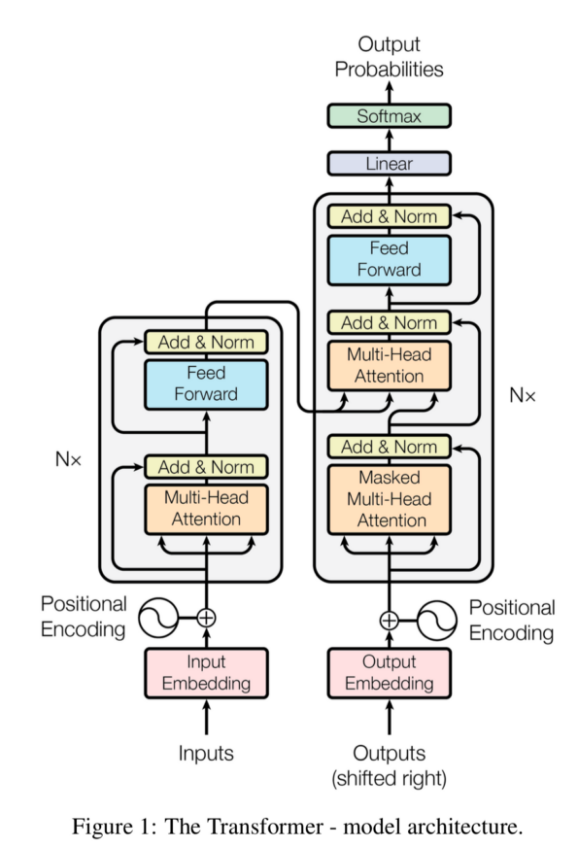   
### - Positional Encoding
- encoder, decoder 층에서 각 input embedding이 들어왔을 때, positional encoding을 진행한다.   
- 아래 수식을 구현한다.


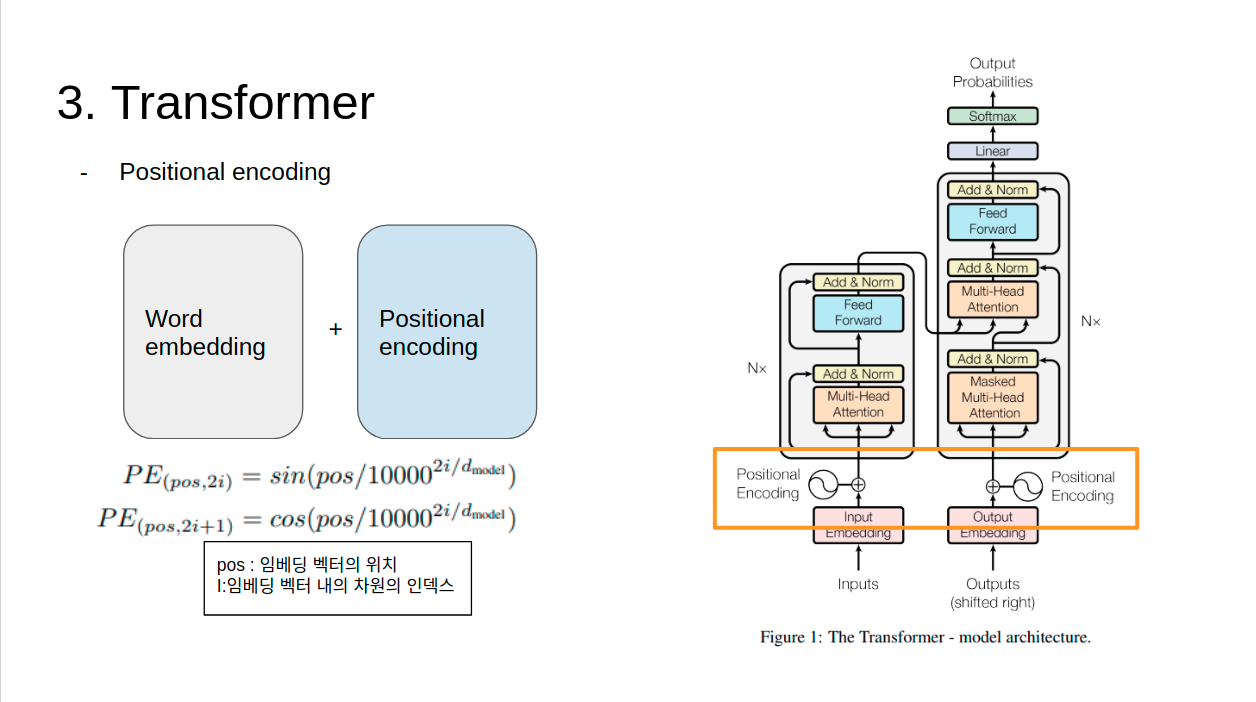

In [120]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

### - Multi-Head Attention
- embedding된 입력(positional encoding 출력)을 head 수로 분할 
- 분할된 입력으로 부터 scaled dot product attention 값을 계산 
- 연산 후, 분할된 head를 하나로 결합  

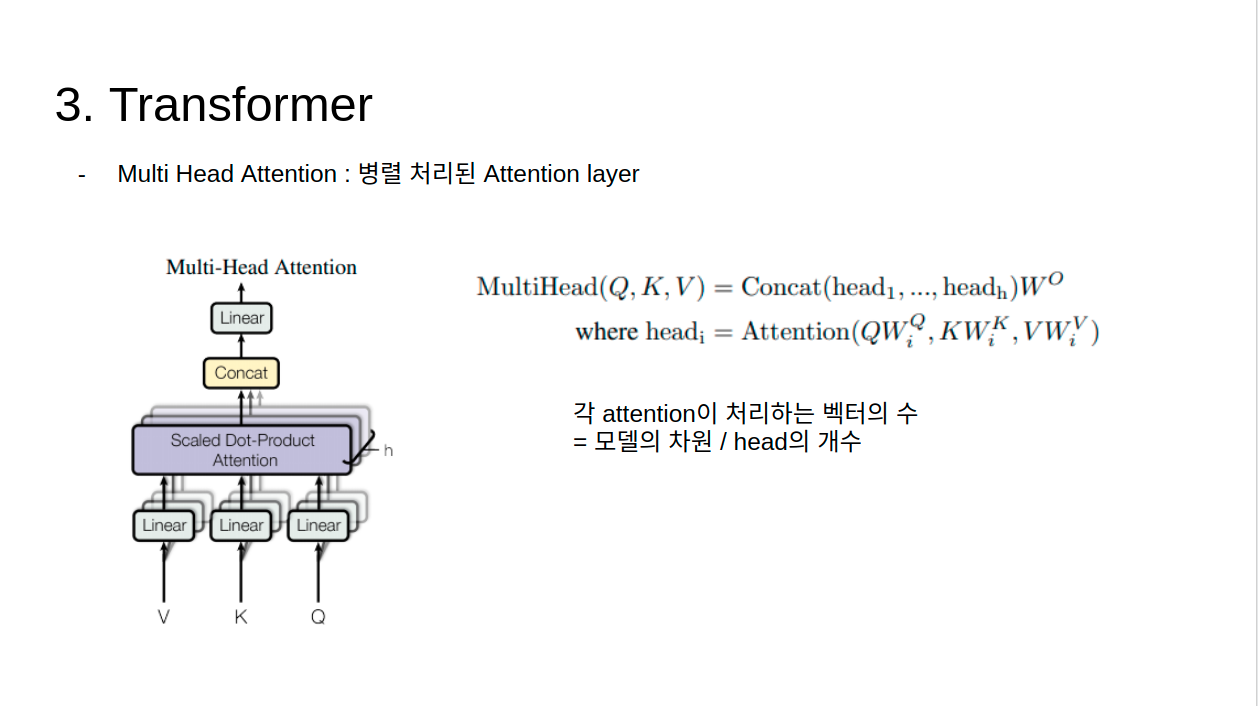  
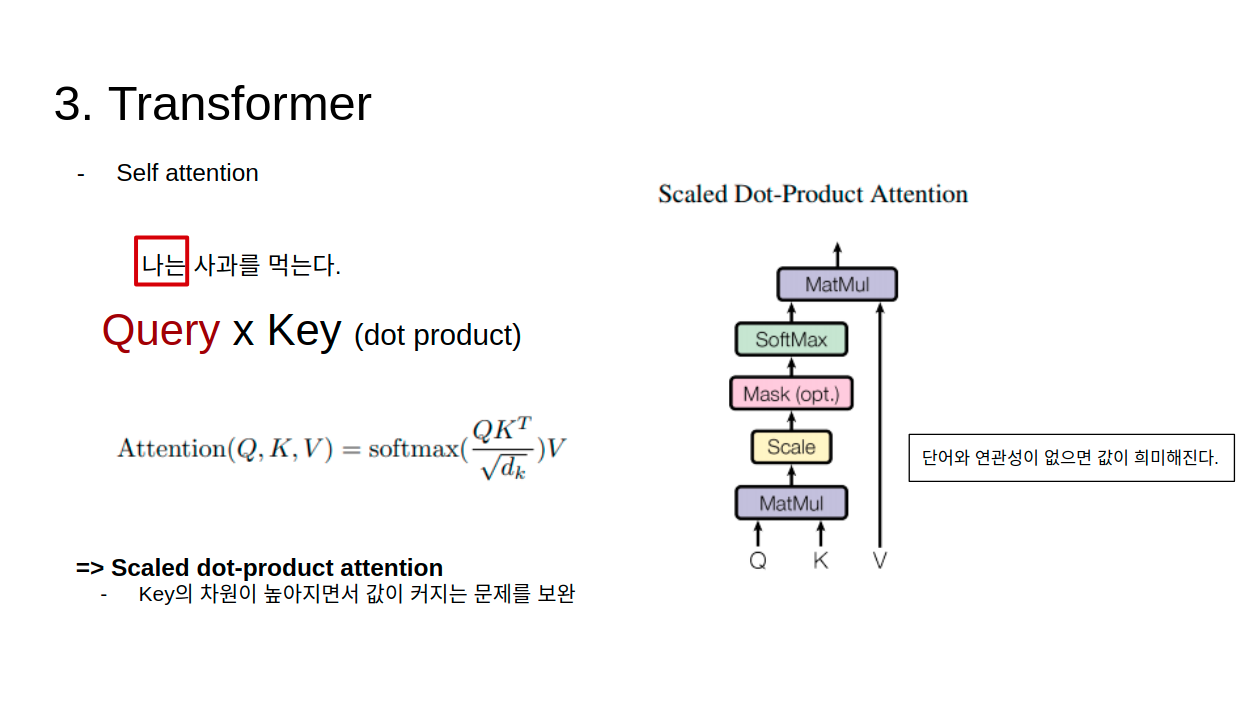

In [121]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

### - Position-wise Feed-Forward Network
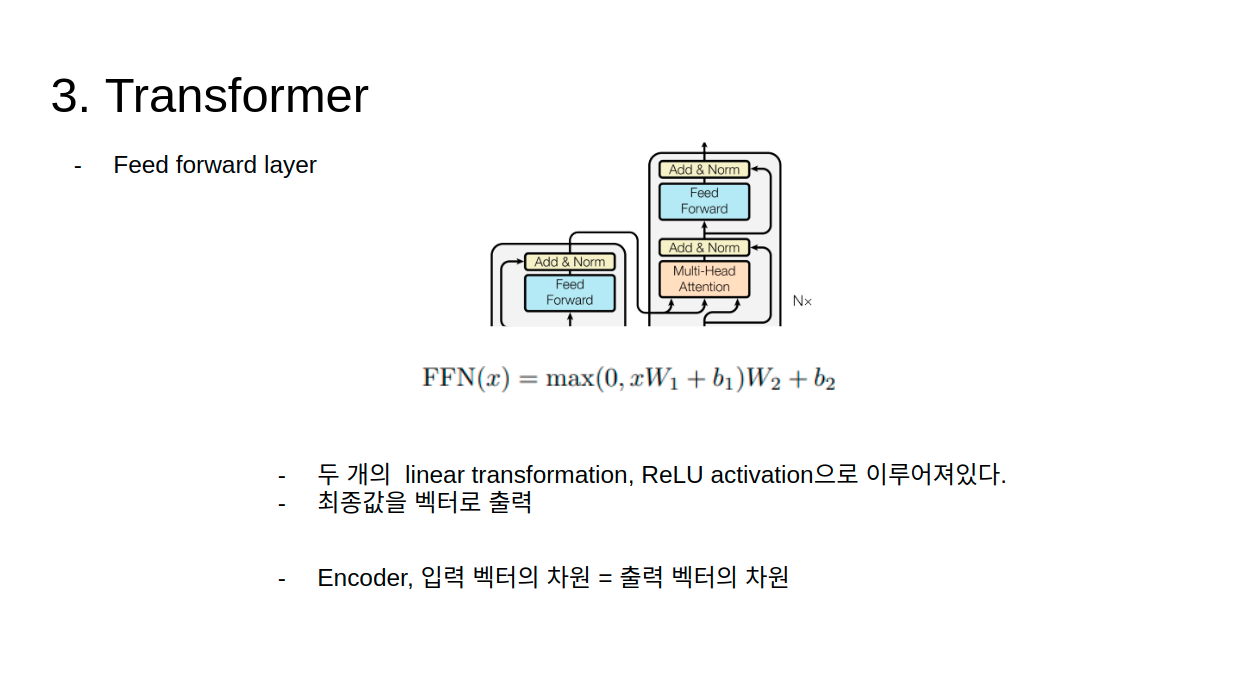

In [122]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

### - Encoder, Decoder layer

In [123]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [124]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### Encoder, Decoder

In [125]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [126]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer

In [127]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

### - mask

In [128]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

### - mask visualization

<function matplotlib.pyplot.show(close=None, block=None)>

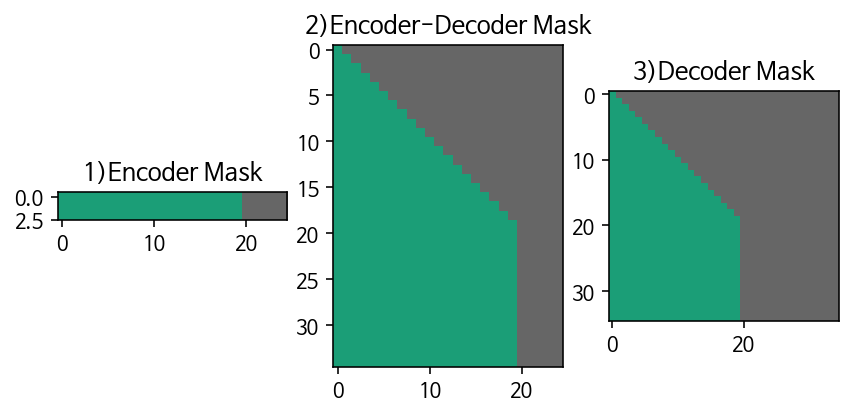

In [129]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1)Encoder Mask')
ax2.set_title('2)Encoder-Decoder Mask')
ax3.set_title('3)Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show

In [130]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
    
learning_rate = LearningRateScheduler(512)
oprimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## 5. 훈련 및 평가

In [131]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=len(enc_train),
    tgt_vocab_size=len(dec_train),
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 512

In [132]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [133]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [134]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

# 루브릭 평가
---
1. **챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?**   

    - 5만개 이상의 데이터를 증강해 생성했다.


2. **transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?**

    - 과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.


3. **챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?** 
 
     - 주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.


    
# 회고
---
## 어려웠던 부분 
- 

## 알아낸 점 혹은 모호한 부분 
- 

## 느낀 점 
- 